# Kees Smit Cross-Season Comparisons
## Smit (25/26) vs Pedri (20/21) vs De Jong (25/26)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# Metrics configuration
mf_metrics = [
    'progressive_passes_per90', 'Carries_PrgC_per90', 'SCA_SCA90', 'expected_assists_per90',
    'passes_penalty_area_per90', 'Take-Ons_Succ_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Fld_per90', 'pass_completion_pct'
]
mf_titles = [
    'Progressive Passes', 'Progressive Carries', 'Shot Creating Actions', 'Expected Assists',
    'Box Passes', 'Dribbles', 'Tackles + Interceptions', 'Interceptions',
    'Fouls Drawn', 'Pass Accuracy %'
]

pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Challenges_Tkl%', 'Carries_PrgC_per90', 'SCA_SCA90', 'Recov_per90',
    'Fld_per90', 'expected_assists_per90'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

SAVE_PATH_BASE = '../images/smit_comparisons/'
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Helper functions
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x)
    return df

In [4]:
# STEP 1: Query Big5 season 20/21
print("="*60)
print("STEP 1: BIG5 SEASON 20/21")
print("="*60)

db = get_db_manager()

LEAGUES_BIG5 = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON_2021 = '2021'

league_list_str = "', '".join(LEAGUES_BIG5)
query_2021 = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic
WHERE league IN ('{league_list_str}')
AND season = '{SEASON_2021}'
ORDER BY league, team, player_name
"""

df_2021_raw = pd.read_sql(query_2021, db.engine)
print(f"Extraídos Big5 20/21: {df_2021_raw.shape[0]} jugadores")

# Extract metrics
fbref_2021 = extract_metrics(df_2021_raw, 'fbref_metrics')
understat_2021 = extract_metrics(df_2021_raw, 'understat_metrics')

# Calculate per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

fbref_2021_per90 = fbref_2021.loc[:, ~fbref_2021.columns.isin(exclude_per90)]
fbref_2021_per90 = (fbref_2021_per90.div(fbref_2021['minutes_played'], axis=0) * 90).round(3)
fbref_2021_per90.columns = [f'{col}_per90' for col in fbref_2021_per90.columns]

understat_2021_per90 = understat_2021.loc[:, ~understat_2021.columns.isin(exclude_per90)]
understat_2021_per90 = (understat_2021_per90.div(fbref_2021['minutes_played'], axis=0) * 90).round(3)
understat_2021_per90.columns = [f'{col}_per90' for col in understat_2021_per90.columns]

# Combine all metrics
all_metrics_2021 = pd.concat([fbref_2021, understat_2021, fbref_2021_per90, understat_2021_per90], axis=1)

# Calculate percentiles
all_percentiles_2021 = all_metrics_2021.rank(pct=True) * 98 + 1
all_percentiles_2021 = all_percentiles_2021.round(0).astype('Int64')
all_percentiles_2021.columns = [f'{col}_pct' for col in all_percentiles_2021.columns]

# Create final DataFrame
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
df_2021 = pd.concat([
    df_2021_raw[base_cols],
    all_metrics_2021,
    all_percentiles_2021
], axis=1)

df_2021 = clean_series_values(df_2021)
df_2021['cohort'] = 'Big5_2021'

print(f"DataFrame 20/21: {df_2021.shape[0]} filas, {df_2021.shape[1]} columnas")
print(f"Percentiles calculados dentro del cohort Big5 20/21")
df_2021.head(3)

2025-11-16 12:12:52,319 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev


STEP 1: BIG5 SEASON 20/21


2025-11-16 12:12:52,593 - database.connection - INFO - Database connection successful


Extraídos Big5 20/21: 2755 jugadores
DataFrame 20/21: 2755 filas, 719 columnas
Percentiles calculados dentro del cohort Big5 20/21


unique_player_id             player_name     team              league  \
0  528b83f69d55c8f1  Ainsley Maitland-Niles  Arsenal  ENG-Premier League   
1  8ff75ef19c34b0a6     Alexandre Lacazette  Arsenal  ENG-Premier League   
2  ba9fda220e84b67f              Bernd Leno  Arsenal  ENG-Premier League   

  season position  Recov  Team Success (xG)_onxG  Passes_AvgLen  \
0   2021    MF,DF   39.0                     8.1            NaN   
1   2021       FW   59.0                    31.8            NaN   
2   2021       GK   39.0                    46.2           25.4   

   Passes_Launch%  ...  Sweeper_AvgDist_per90_pct  GCA Types_Fld_per90_pct  \
0             NaN  ...                       <NA>                       98   
1             NaN  ...                       <NA>                       88   
2            17.2  ...                         16                       41   

   understat_xg_buildup_per90_pct  understat_xa_per90_pct  \
0                              97                      80   
1                              40                      69   
2                              36                      11   

   understat_key_passes_per90_pct  understat_npxg_plus_xa_per90_pct  \
0                              72                                67   
1                              69                                89   
2                              10                              <NA>   

   understat_np_xg_per90_pct  understat_xg_chain_per90_pct  \
0                         72                            96   
1                         94                            88   
2                         10                            20   

   understat_np_goals_per90_pct     cohort  
0                            26  Big5_2021  
1                            94  Big5_2021  
2                            26  Big5_2021  

[3 rows x 719 columns]

In [5]:
# STEP 2: Query Big5 + Eredivisie season 25/26
print("\n" + "="*60)
print("STEP 2: BIG5 + EREDIVISIE SEASON 25/26")
print("="*60)

SEASON_2526 = '2526'

# Query Big5 from players_domestic
query_big5_2526 = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic
WHERE league IN ('{league_list_str}')
AND season = '{SEASON_2526}'
ORDER BY league, team, player_name
"""

# Query Eredivisie from players_extras
query_eredivisie_2526 = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_extras
WHERE league = 'NED-Eredivisie'
AND season = '{SEASON_2526}'
ORDER BY team, player_name
"""

df_big5_2526 = pd.read_sql(query_big5_2526, db.engine)
df_eredivisie_2526 = pd.read_sql(query_eredivisie_2526, db.engine)

print(f"Extraídos Big5 25/26: {df_big5_2526.shape[0]} jugadores")
print(f"Extraídos Eredivisie 25/26: {df_eredivisie_2526.shape[0]} jugadores")

# Combine both
df_2526_raw = pd.concat([df_big5_2526, df_eredivisie_2526], ignore_index=True)
print(f"Total combinado 25/26: {df_2526_raw.shape[0]} jugadores")

# Extract metrics
fbref_2526 = extract_metrics(df_2526_raw, 'fbref_metrics')
understat_2526 = extract_metrics(df_2526_raw, 'understat_metrics')

# Calculate per90
fbref_2526_per90 = fbref_2526.loc[:, ~fbref_2526.columns.isin(exclude_per90)]
fbref_2526_per90 = (fbref_2526_per90.div(fbref_2526['minutes_played'], axis=0) * 90).round(3)
fbref_2526_per90.columns = [f'{col}_per90' for col in fbref_2526_per90.columns]

understat_2526_per90 = understat_2526.loc[:, ~understat_2526.columns.isin(exclude_per90)]
understat_2526_per90 = (understat_2526_per90.div(fbref_2526['minutes_played'], axis=0) * 90).round(3)
understat_2526_per90.columns = [f'{col}_per90' for col in understat_2526_per90.columns]

# Combine all metrics
all_metrics_2526 = pd.concat([fbref_2526, understat_2526, fbref_2526_per90, understat_2526_per90], axis=1)

# Calculate percentiles
all_percentiles_2526 = all_metrics_2526.rank(pct=True) * 98 + 1
all_percentiles_2526 = all_percentiles_2526.round(0).astype('Int64')
all_percentiles_2526.columns = [f'{col}_pct' for col in all_percentiles_2526.columns]

# Create final DataFrame
df_2526 = pd.concat([
    df_2526_raw[base_cols],
    all_metrics_2526,
    all_percentiles_2526
], axis=1)

df_2526 = clean_series_values(df_2526)
df_2526['cohort'] = 'Big5+Eredivisie_2526'

print(f"DataFrame 25/26: {df_2526.shape[0]} filas, {df_2526.shape[1]} columnas")
print(f"Percentiles calculados dentro del cohort Big5+Eredivisie 25/26")
df_2526.head(3)


STEP 2: BIG5 + EREDIVISIE SEASON 25/26
Extraídos Big5 25/26: 2254 jugadores
Extraídos Eredivisie 25/26: 425 jugadores
Total combinado 25/26: 2679 jugadores
DataFrame 25/26: 2679 filas, 719 columnas
Percentiles calculados dentro del cohort Big5+Eredivisie 25/26


unique_player_id         player_name     team              league season  \
0  4297cac0772af3c8           Ben White  Arsenal  ENG-Premier League   2526   
1  258ed61985702bb2         Bukayo Saka  Arsenal  ENG-Premier League   2526   
2  278433de9fa4c551  Christian Nørgaard  Arsenal  ENG-Premier League   2526   

  position  Recov  Team Success (xG)_onxG  Passes_AvgLen  Passes_Launch%  ...  \
0       DF    4.0                     1.1            NaN             NaN  ...   
1       FW   32.0                     9.5            NaN             NaN  ...   
2       MF    1.0                     0.0            NaN             NaN  ...   

   Sweeper_AvgDist_per90_pct  GCA Types_Fld_per90_pct  \
0                       <NA>                       47   
1                       <NA>                       96   
2                       <NA>                       47   

   understat_xg_buildup_per90_pct  understat_xa_per90_pct  \
0                              50                      58   
1                              94                      95   
2                               5                      12   

   understat_key_passes_per90_pct  understat_npxg_plus_xa_per90_pct  \
0                              72                                24   
1                              95                                93   
2                              12                              <NA>   

   understat_np_xg_per90_pct  understat_xg_chain_per90_pct  \
0                         34                            39   
1                         87                            95   
2                         99                            98   

   understat_np_goals_per90_pct                cohort  
0                            34  Big5+Eredivisie_2526  
1                            88  Big5+Eredivisie_2526  
2                            34  Big5+Eredivisie_2526  

[3 rows x 719 columns]

In [6]:
# STEP 3: Union both DataFrames
print("\n" + "="*60)
print("STEP 3: UNION DATAFRAMES")
print("="*60)

df_final = pd.concat([df_2021, df_2526], ignore_index=True)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_2021.shape[1]} columnas")
print(f"\nCohorts:")
print(df_final['cohort'].value_counts())
print(f"\nSeasons:")
print(df_final['season'].value_counts())
print(f"\nLeagues:")
print(df_final['league'].value_counts().head(10))

db.close()


STEP 3: UNION DATAFRAMES
DataFrame final: 5434 filas, 719 columnas

Cohorts:
cohort
Big5_2021               2755
Big5+Eredivisie_2526    2679
Name: count, dtype: int64

Seasons:
season
2021    2755
2526    2679
Name: count, dtype: int64

Leagues:
league
ITA-Serie A           1076
ESP-La Liga           1051
FRA-Ligue 1           1014
ENG-Premier League     966
GER-Bundesliga         902
NED-Eredivisie         425
Name: count, dtype: int64


In [7]:
# STEP 4: Search for players
print("\n" + "="*60)
print("STEP 4: SEARCH PLAYERS")
print("="*60)

player_ids = {}

# Search Pedri in 2021 cohort
pedri_search = df_final[
    (df_final['player_name'].str.contains('Pedri', case=False, na=False)) &
    (df_final['cohort'] == 'Big5_2021') &
    (df_final['team'].str.contains('Barcelona', case=False, na=False))
]

if len(pedri_search) > 0:
    pedri_row = pedri_search.iloc[0]
    player_ids['Pedri'] = pedri_row['unique_player_id']
    print(f"✓ Pedri encontrado: {pedri_row['player_name']} ({pedri_row['team']}, {pedri_row['season']})")
    print(f"   ID: {player_ids['Pedri']}")
else:
    print("✗ Pedri NO encontrado en 20/21")

# Search De Jong in 2526 cohort
dejong_search = df_final[
    (df_final['player_name'].str.contains('Jong', case=False, na=False)) &
    (df_final['player_name'].str.contains('Frenkie', case=False, na=False)) &
    (df_final['cohort'] == 'Big5+Eredivisie_2526') &
    (df_final['team'].str.contains('Barcelona', case=False, na=False))
]

if len(dejong_search) > 0:
    dejong_row = dejong_search.iloc[0]
    player_ids['De Jong'] = dejong_row['unique_player_id']
    print(f"✓ De Jong encontrado: {dejong_row['player_name']} ({dejong_row['team']}, {dejong_row['season']})")
    print(f"   ID: {player_ids['De Jong']}")
else:
    print("✗ De Jong NO encontrado en 25/26")

# Search Kees Smit in 2526 cohort (Eredivisie)
smit_search = df_final[
    (df_final['player_name'].str.contains('Smit', case=False, na=False)) &
    (df_final['player_name'].str.contains('Kees', case=False, na=False)) &
    (df_final['cohort'] == 'Big5+Eredivisie_2526') &
    (df_final['league'] == 'NED-Eredivisie')
]

if len(smit_search) > 0:
    smit_row = smit_search.iloc[0]
    player_ids['Kees Smit'] = smit_row['unique_player_id']
    print(f"✓ Kees Smit encontrado: {smit_row['player_name']} ({smit_row['team']}, {smit_row['season']})")
    print(f"   ID: {player_ids['Kees Smit']}")
else:
    print("✗ Kees Smit NO encontrado en Eredivisie 25/26")

print(f"\n{'='*60}")
print(f"TOTAL PLAYERS FOUND: {len(player_ids)}/3")
for name, pid in player_ids.items():
    print(f"  {name}: {pid}")


STEP 4: SEARCH PLAYERS
✓ Pedri encontrado: Pedri (Barcelona, 2021)
   ID: 8c50fb1a1662d90f
✓ De Jong encontrado: Frenkie de Jong (Barcelona, 2526)
   ID: 15e796b4abf12304
✓ Kees Smit encontrado: Kees Smit (AZ Alkmaar, 2526)
   ID: b47122a8d09a70a3

TOTAL PLAYERS FOUND: 3/3
  Pedri: 8c50fb1a1662d90f
  De Jong: 15e796b4abf12304
  Kees Smit: b47122a8d09a70a3



COMPARISON 1: PEDRI VS SMIT (MF METRICS)
Dataset MF: 1772 jugadores
✓ Completed: pedri_vs_smit_combined.png


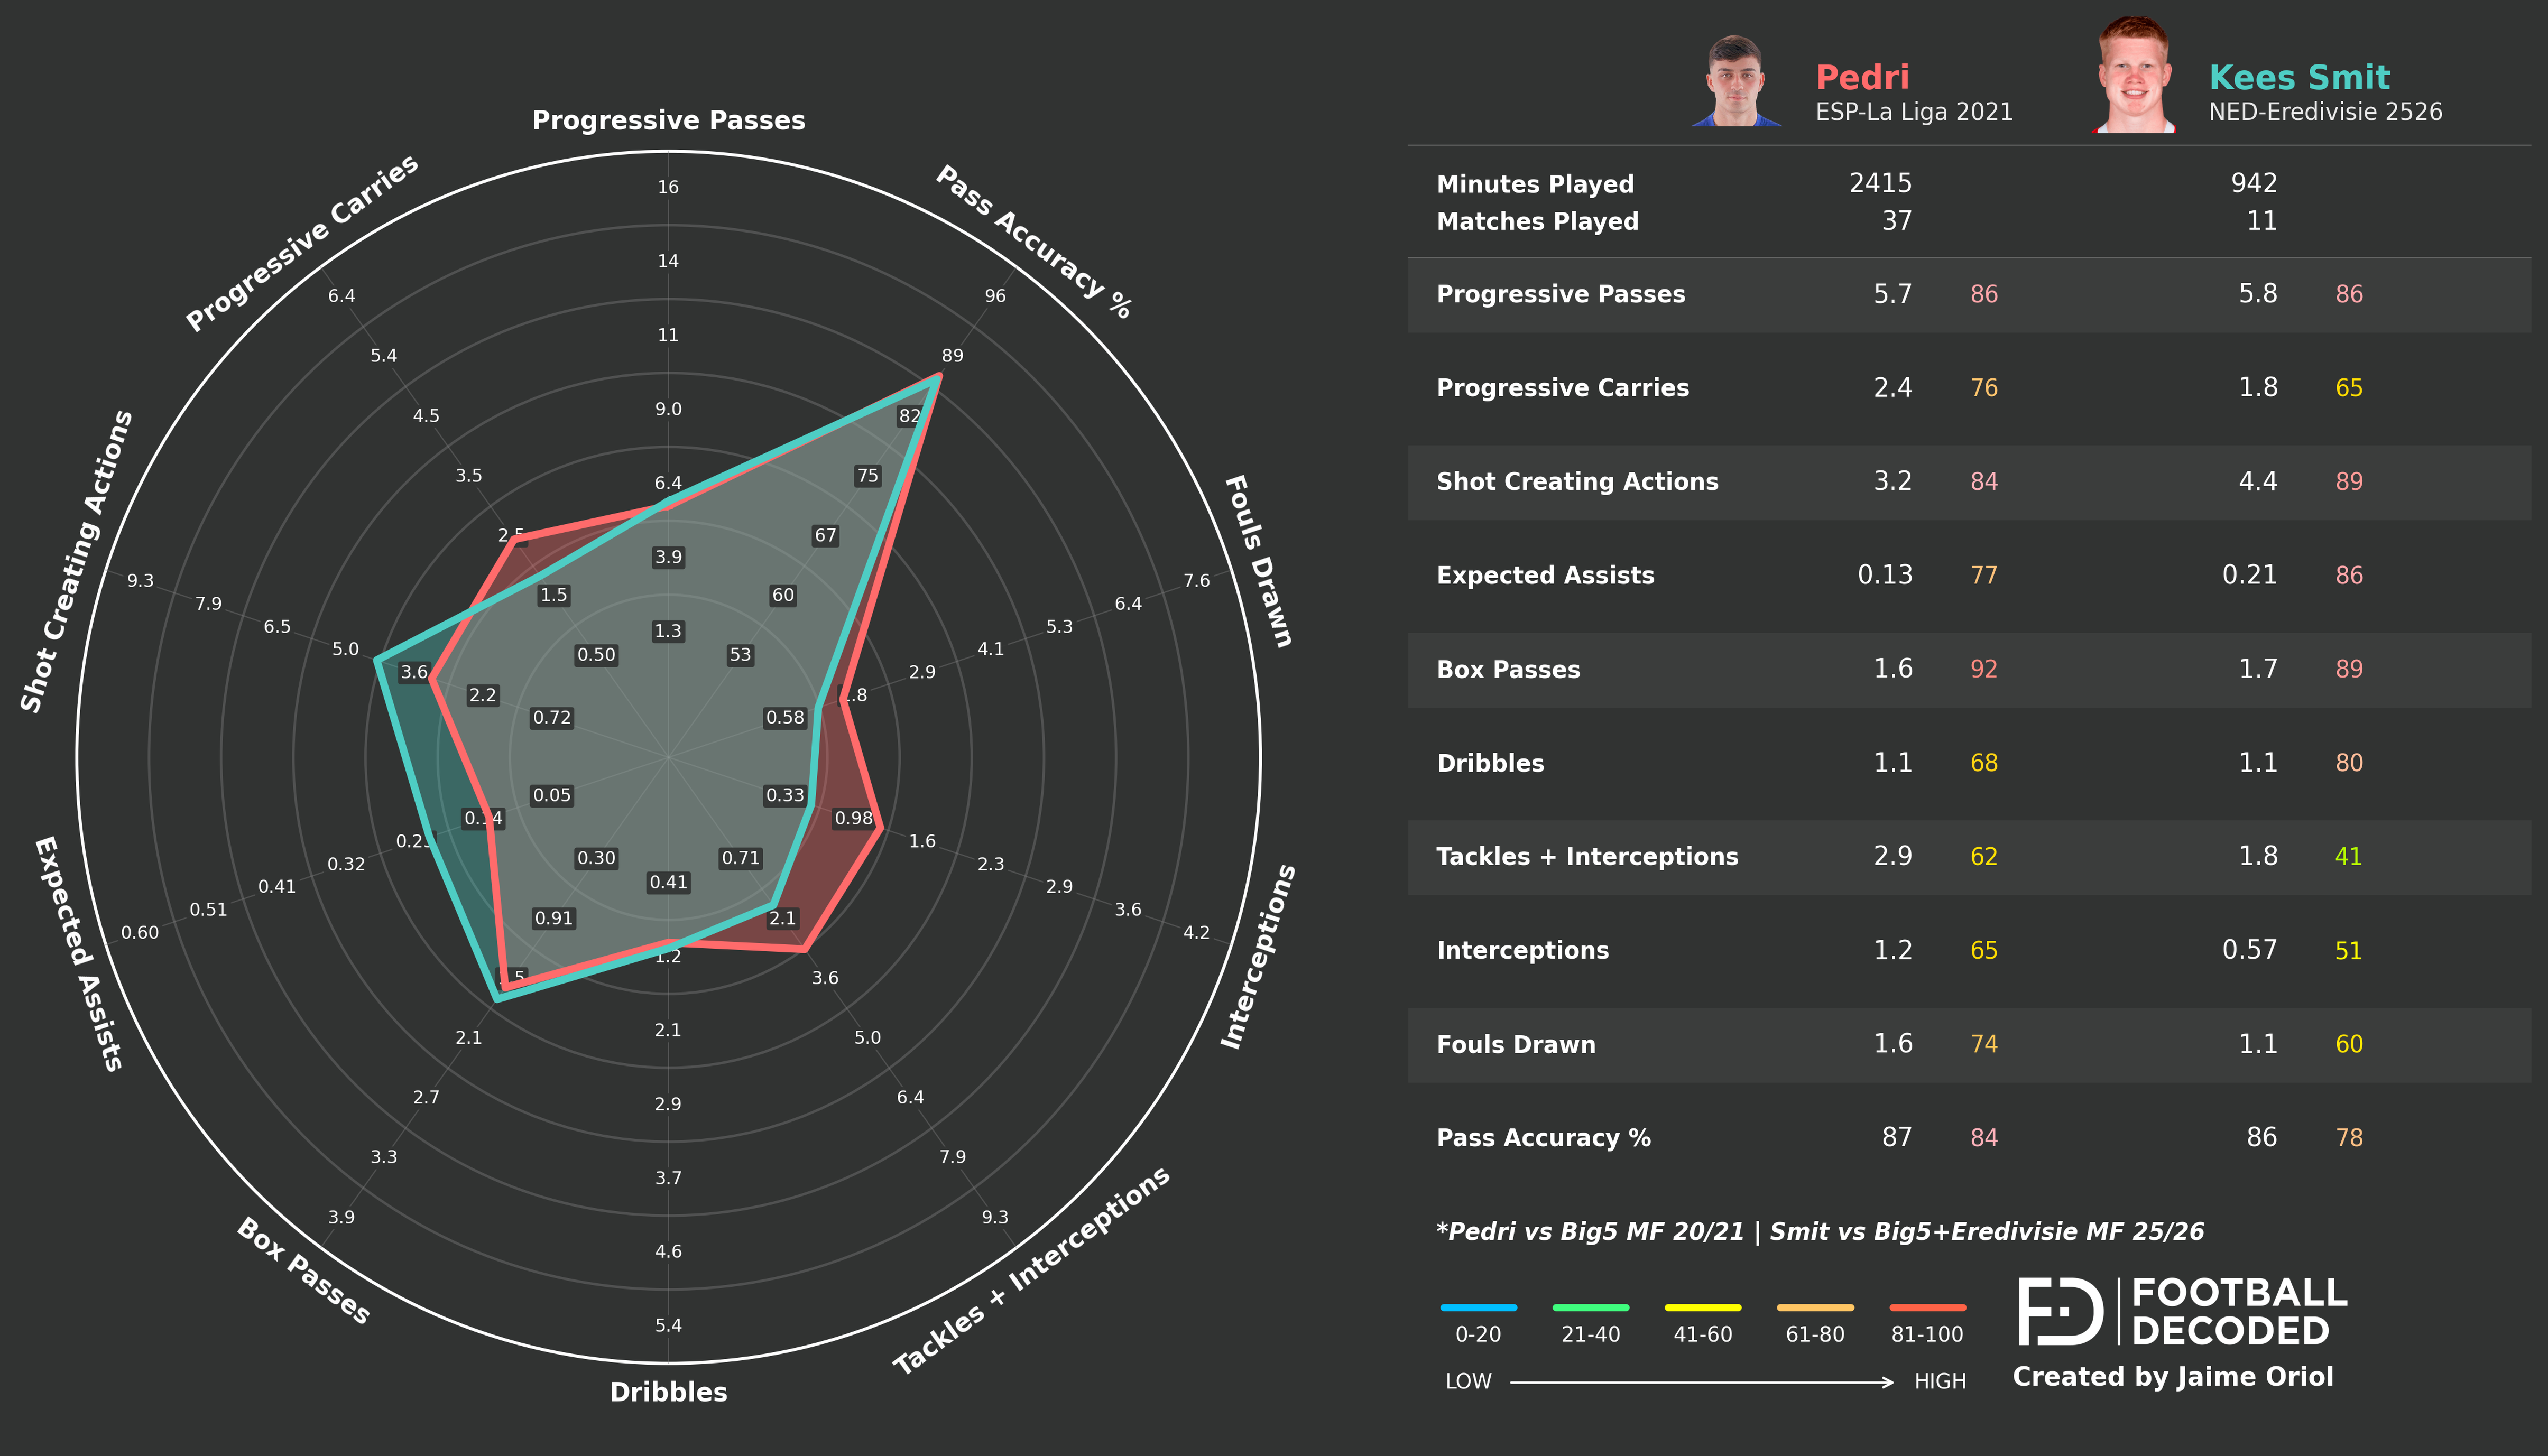

In [12]:
# COMPARISON 1: Pedri vs Smit (MF)
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("\n" + "="*60)
print("COMPARISON 1: PEDRI VS SMIT (MF METRICS)")
print("="*60)

if 'Pedri' in player_ids and 'Kees Smit' in player_ids:
    pedri_id = player_ids['Pedri']
    smit_id = player_ids['Kees Smit']
    
    # Dataset: Filter MF players only
    df_mf = df_final[df_final['position'].str.startswith('MF')].copy()
    print(f"Dataset MF: {df_mf.shape[0]} jugadores")
    
    # Colors - Template default colors (contraste cian/rojo)
    pedri_color = '#FF6B6B'  # Coral Red
    smit_color = '#4ECDC4'   # Turquoise/Cyan
    team_colors = [pedri_color, smit_color]
    
    # Team logos - usando caras de jugadores
    pedri_team = df_final.loc[df_final['unique_player_id'] == pedri_id, 'team'].iloc[0]
    smit_team = df_final.loc[df_final['unique_player_id'] == smit_id, 'team'].iloc[0]
    
    team_logos = {
        pedri_team: '../caras/extras/Pedri.png',
        smit_team: '../caras/extras/Smit.png'
    }
    
    try:
        # Create radar
        create_player_radar(
            df_data=df_mf,
            player_1_id=pedri_id,
            player_2_id=smit_id,
            metrics=mf_metrics,
            metric_titles=mf_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}pedri_vs_smit_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_mf,
            player_1_id=pedri_id,
            player_2_id=smit_id,
            metrics=mf_metrics,
            metric_titles=mf_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}pedri_vs_smit_table.png",
            footer_text="Pedri vs Big5 MF 20/21 | Smit vs Big5+Eredivisie MF 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}pedri_vs_smit_radar.png",
            table_path=f"{SAVE_PATH_BASE}pedri_vs_smit_table.png",
            output_path=f"{SAVE_PATH_BASE}pedri_vs_smit_combined.png"
        )
        
        print(f"✓ Completed: pedri_vs_smit_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}pedri_vs_smit_combined.png"))
        
    except Exception as e:
        print(f"✗ Error: {e}")
else:
    print("✗ Missing player IDs")


COMPARISON 2: DE JONG VS SMIT (MF METRICS)
Dataset MF 25/26: 870 jugadores
✓ Completed: dejong_vs_smit_mf_combined.png


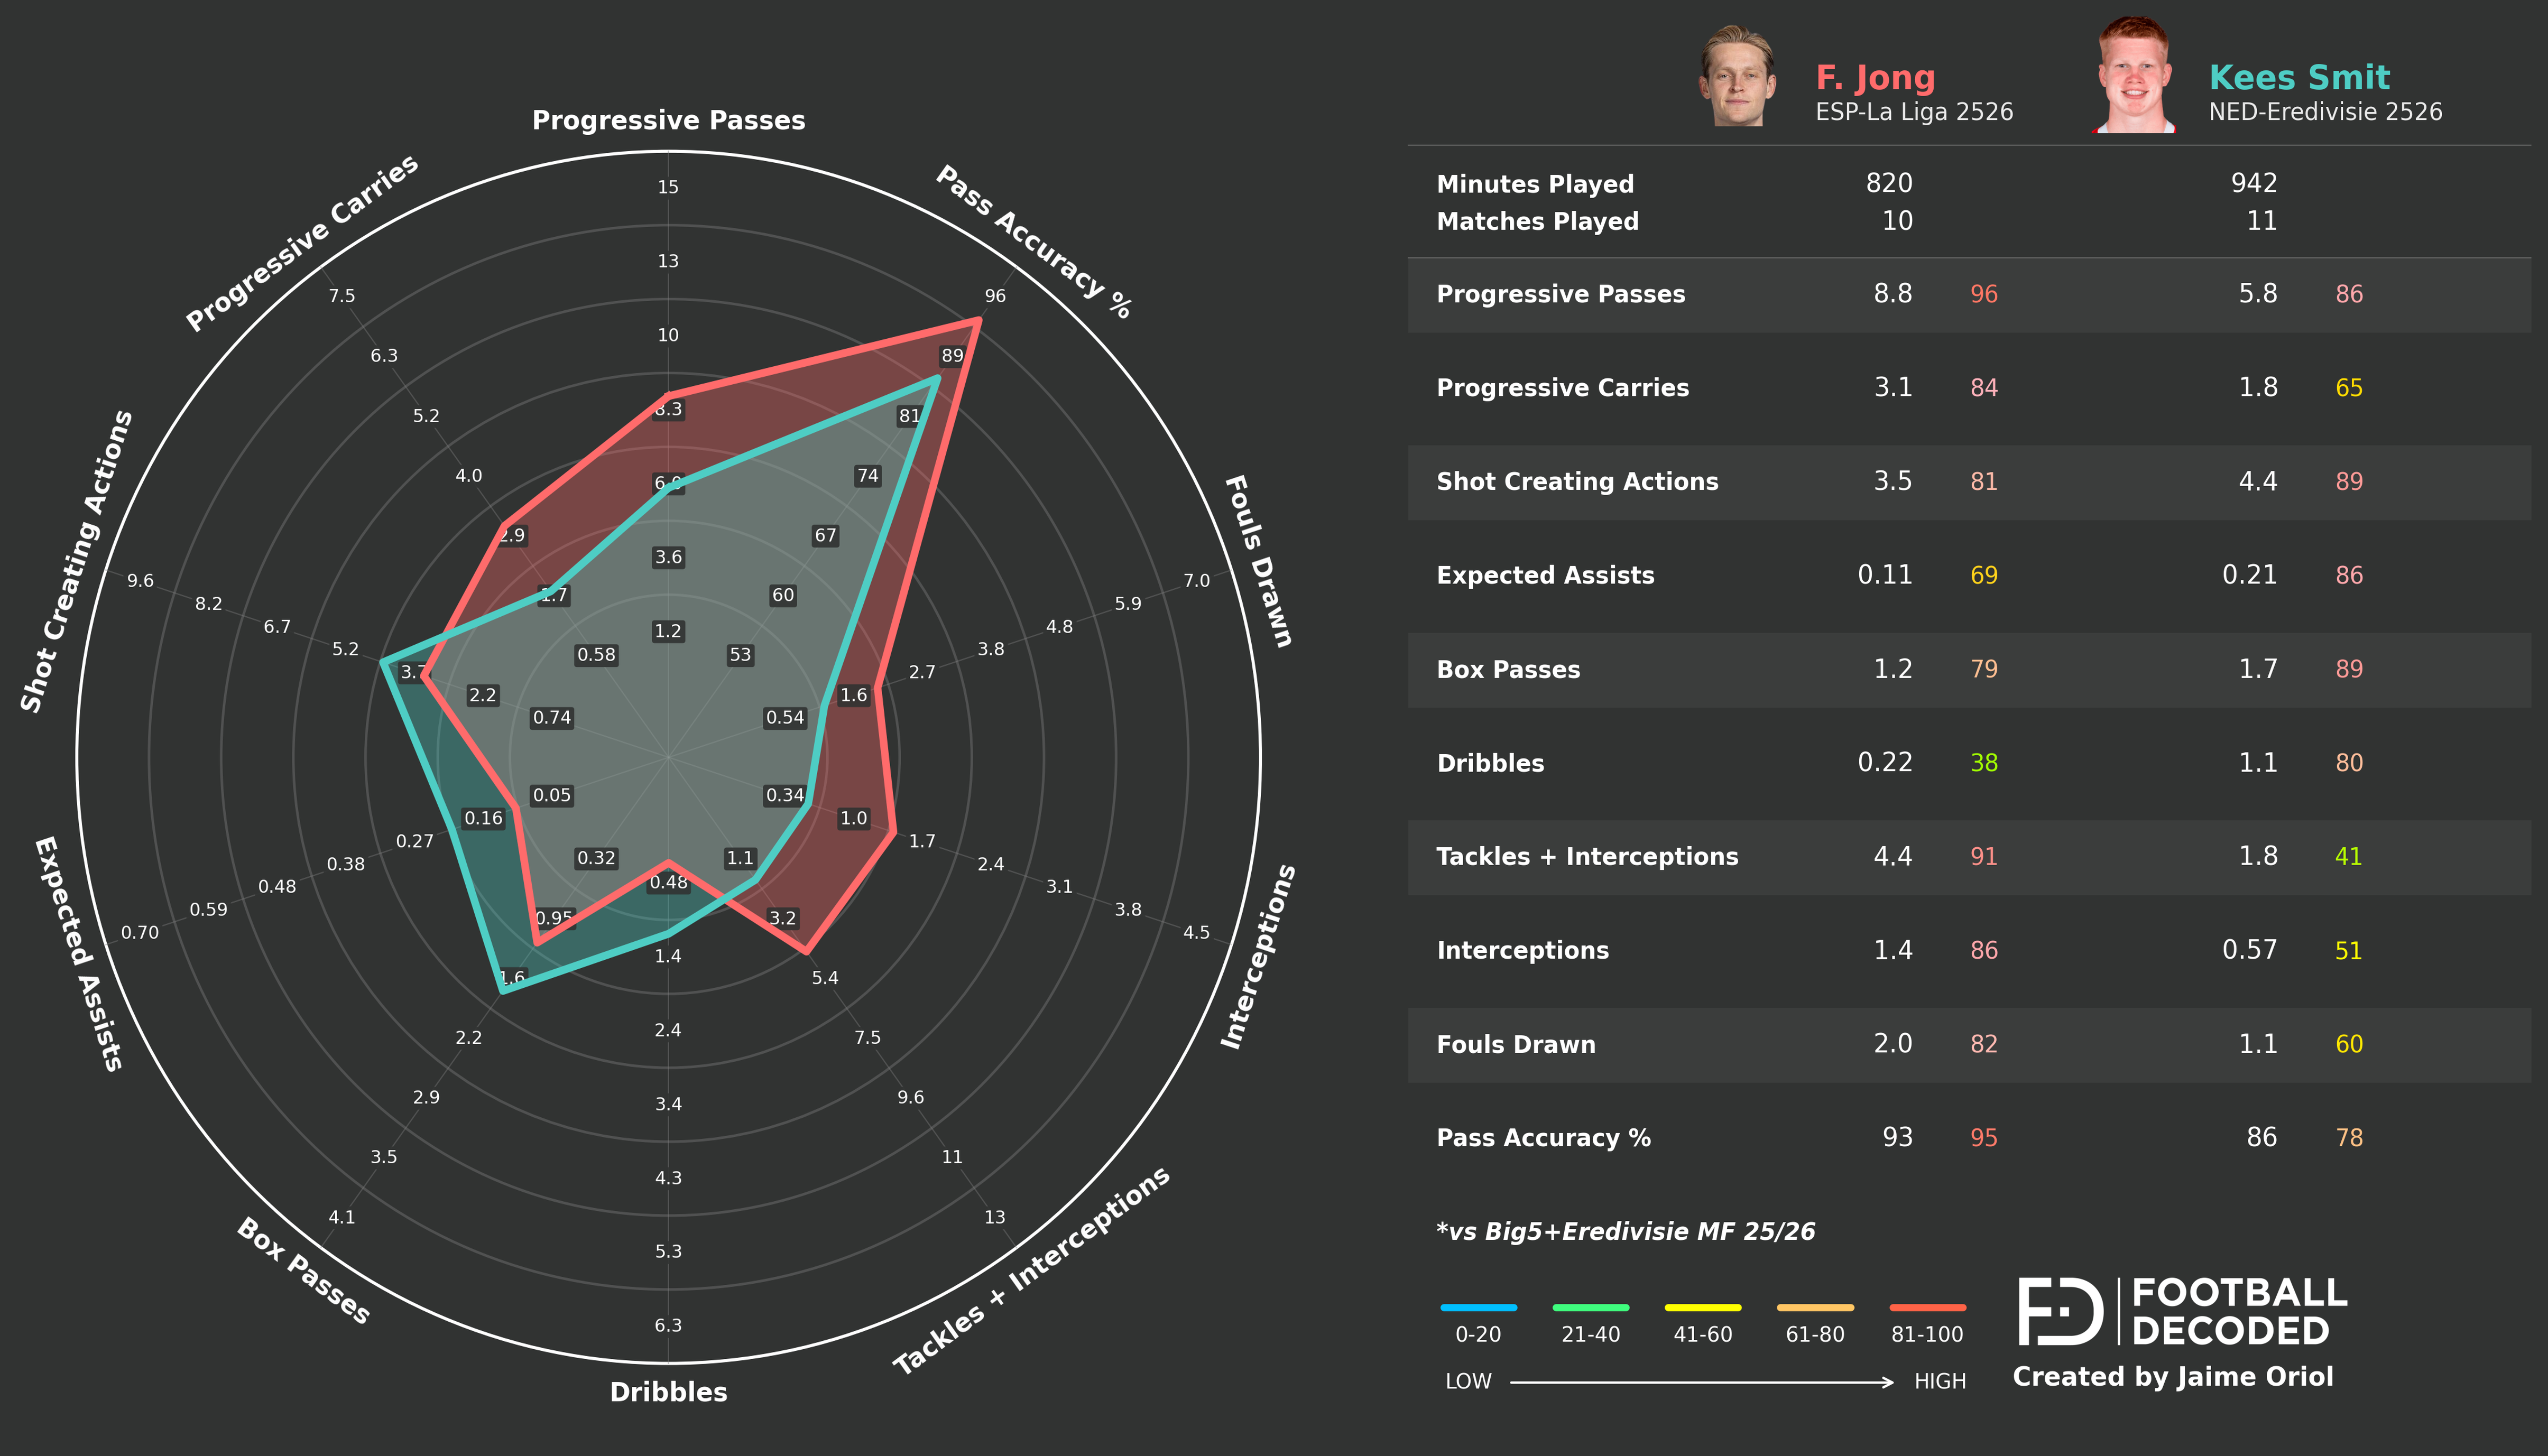

In [13]:
# COMPARISON 2: De Jong vs Smit (MF)
print("\n" + "="*60)
print("COMPARISON 2: DE JONG VS SMIT (MF METRICS)")
print("="*60)

if 'De Jong' in player_ids and 'Kees Smit' in player_ids:
    dejong_id = player_ids['De Jong']
    smit_id = player_ids['Kees Smit']
    
    # Dataset: Filter MF players only (25/26 cohort)
    df_mf_2526 = df_final[
        (df_final['position'].str.startswith('MF')) &
        (df_final['cohort'] == 'Big5+Eredivisie_2526')
    ].copy()
    print(f"Dataset MF 25/26: {df_mf_2526.shape[0]} jugadores")
    
    # Colors - Template default colors
    dejong_color = '#FF6B6B'  # Coral Red
    smit_color = '#4ECDC4'    # Turquoise/Cyan
    team_colors = [dejong_color, smit_color]
    
    # Team logos - usando caras de jugadores
    dejong_team = df_final.loc[df_final['unique_player_id'] == dejong_id, 'team'].iloc[0]
    smit_team = df_final.loc[df_final['unique_player_id'] == smit_id, 'team'].iloc[0]
    
    team_logos = {
        dejong_team: '../caras/extras/DeJong.png',
        smit_team: '../caras/extras/Smit.png'
    }
    
    try:
        # Create radar
        create_player_radar(
            df_data=df_mf_2526,
            player_1_id=dejong_id,
            player_2_id=smit_id,
            metrics=mf_metrics,
            metric_titles=mf_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}dejong_vs_smit_mf_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_mf_2526,
            player_1_id=dejong_id,
            player_2_id=smit_id,
            metrics=mf_metrics,
            metric_titles=mf_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}dejong_vs_smit_mf_table.png",
            footer_text="vs Big5+Eredivisie MF 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}dejong_vs_smit_mf_radar.png",
            table_path=f"{SAVE_PATH_BASE}dejong_vs_smit_mf_table.png",
            output_path=f"{SAVE_PATH_BASE}dejong_vs_smit_mf_combined.png"
        )
        
        print(f"✓ Completed: dejong_vs_smit_mf_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}dejong_vs_smit_mf_combined.png"))
        
    except Exception as e:
        print(f"✗ Error: {e}")
else:
    print("✗ Missing player IDs")


COMPARISON 3: DE JONG VS SMIT (PIVOTE METRICS)
Dataset Pivote 25/26: 870 jugadores
✓ Completed: dejong_vs_smit_pivote_combined.png


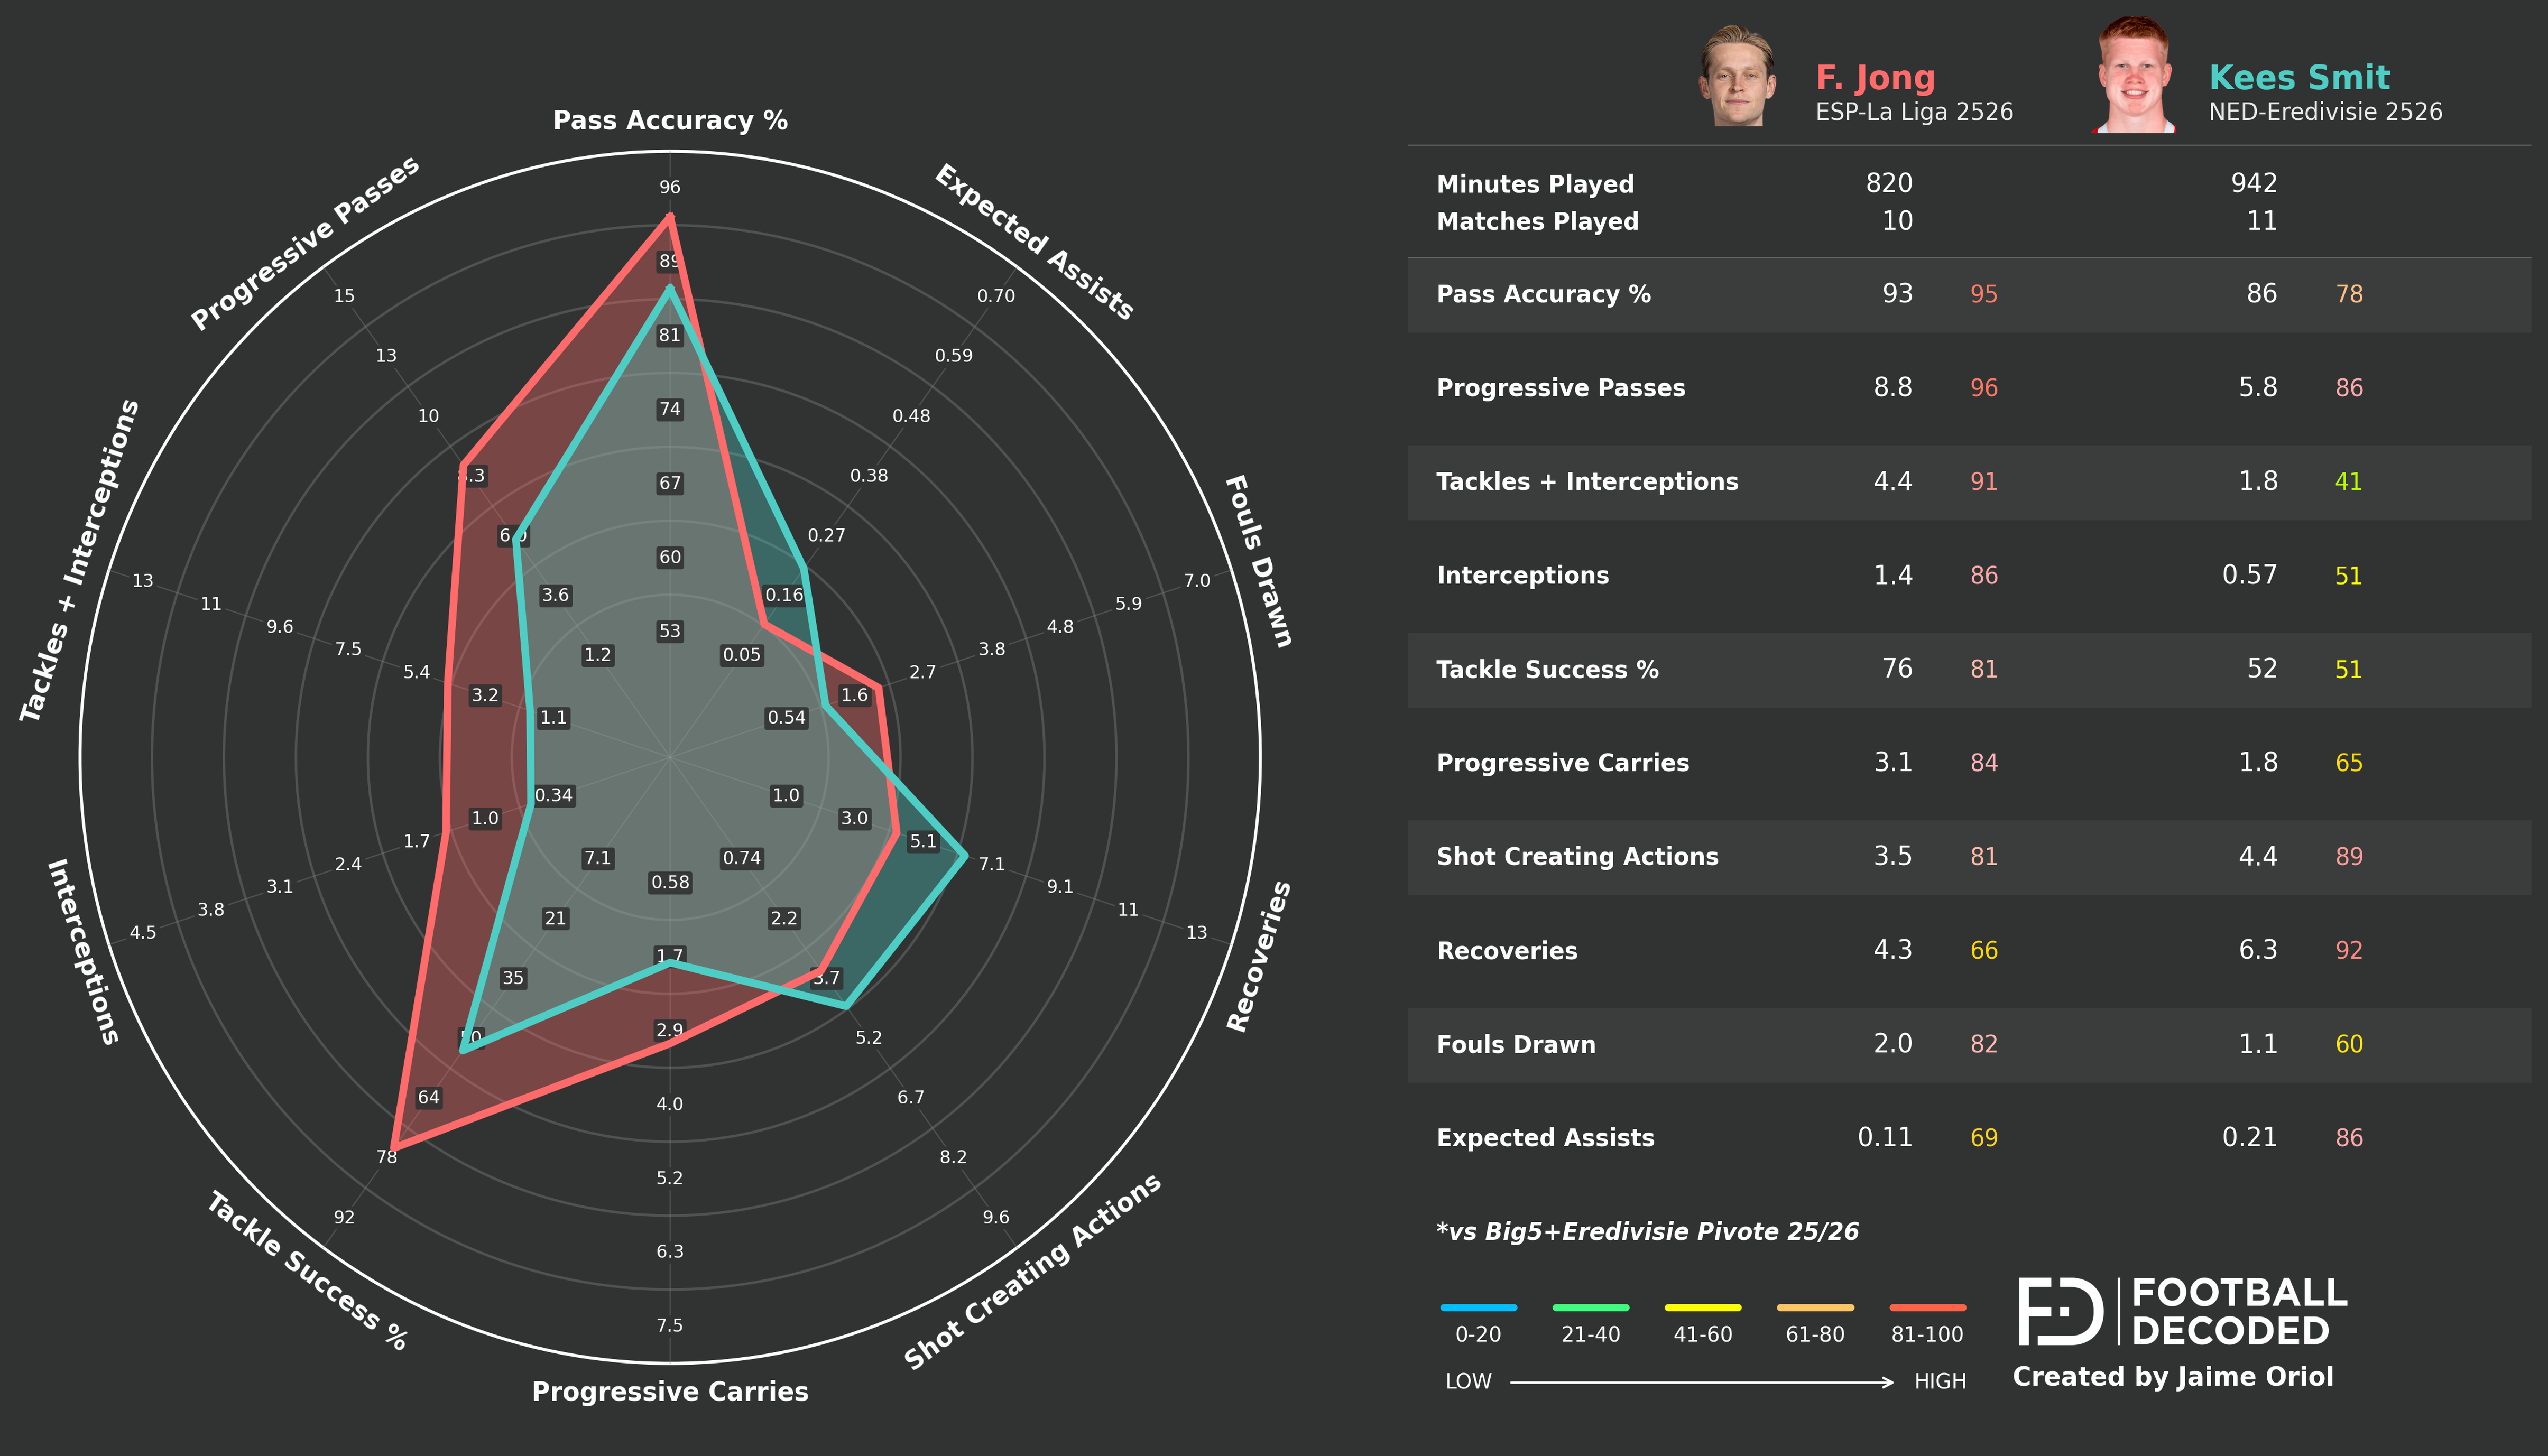


ALL COMPARISONS COMPLETED
Output directory: ../images/smit_comparisons/
Files generated:
  1. pedri_vs_smit_combined.png
  2. dejong_vs_smit_mf_combined.png
  3. dejong_vs_smit_pivote_combined.png


In [14]:
# COMPARISON 3: De Jong vs Smit (PIVOTE)
print("\n" + "="*60)
print("COMPARISON 3: DE JONG VS SMIT (PIVOTE METRICS)")
print("="*60)

if 'De Jong' in player_ids and 'Kees Smit' in player_ids:
    dejong_id = player_ids['De Jong']
    smit_id = player_ids['Kees Smit']
    
    # Dataset: Filter MF players only (25/26 cohort) - same as comparison 2
    # Pivotes are also MF position
    df_pivote_2526 = df_final[
        (df_final['position'].str.startswith('MF')) &
        (df_final['cohort'] == 'Big5+Eredivisie_2526')
    ].copy()
    print(f"Dataset Pivote 25/26: {df_pivote_2526.shape[0]} jugadores")
    
    # Colors - Template default colors
    dejong_color = '#FF6B6B'  # Coral Red
    smit_color = '#4ECDC4'    # Turquoise/Cyan
    team_colors = [dejong_color, smit_color]
    
    # Team logos - usando caras de jugadores
    dejong_team = df_final.loc[df_final['unique_player_id'] == dejong_id, 'team'].iloc[0]
    smit_team = df_final.loc[df_final['unique_player_id'] == smit_id, 'team'].iloc[0]
    
    team_logos = {
        dejong_team: '../caras/extras/DeJong.png',
        smit_team: '../caras/extras/Smit.png'
    }
    
    try:
        # Create radar - BOTH using PIVOTE metrics
        create_player_radar(
            df_data=df_pivote_2526,
            player_1_id=dejong_id,
            player_2_id=smit_id,
            metrics=pivote_metrics,
            metric_titles=pivote_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Create table
        create_stats_table(
            df_data=df_pivote_2526,
            player_1_id=dejong_id,
            player_2_id=smit_id,
            metrics=pivote_metrics,
            metric_titles=pivote_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_table.png",
            footer_text="vs Big5+Eredivisie Pivote 25/26",
            show_plot=False
        )
        
        # Combine
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_radar.png",
            table_path=f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_table.png",
            output_path=f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_combined.png"
        )
        
        print(f"✓ Completed: dejong_vs_smit_pivote_combined.png")
        display(IPImage(f"{SAVE_PATH_BASE}dejong_vs_smit_pivote_combined.png"))
        
    except Exception as e:
        print(f"✗ Error: {e}")
else:
    print("✗ Missing player IDs")

print("\n" + "="*60)
print("ALL COMPARISONS COMPLETED")
print("="*60)
print(f"Output directory: {SAVE_PATH_BASE}")
print(f"Files generated:")
print(f"  1. pedri_vs_smit_combined.png")
print(f"  2. dejong_vs_smit_mf_combined.png")
print(f"  3. dejong_vs_smit_pivote_combined.png")